# **Hand Recognition - CNN, Model**

### **Dataset Downlaoding**

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
dataset_url="https://www.kaggle.com/datasets/gti-upm/leapgestrecog"
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adil6572
Your Kaggle Key: ··········


100%|██████████| 2.13G/2.13G [00:26<00:00, 87.9MB/s]


### **Importing libraries**

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [4]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'08_palm_moved': 0,
 '03_fist': 1,
 '06_index': 2,
 '05_thumb': 3,
 '04_fist_moved': 4,
 '09_c': 5,
 '02_l': 6,
 '01_palm': 7,
 '07_ok': 8,
 '10_down': 9}

10 classes are found for the classification of images

In [74]:
reverselookup

{0: '08_palm_moved',
 1: '03_fist',
 2: '06_index',
 3: '05_thumb',
 4: '04_fist_moved',
 5: '09_c',
 6: '02_l',
 7: '01_palm',
 8: '07_ok',
 9: '10_down'}

### **Preparing the dataset**

In [5]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('leapgestrecog/leapGestRecog/0' +
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = 'leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1
            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)

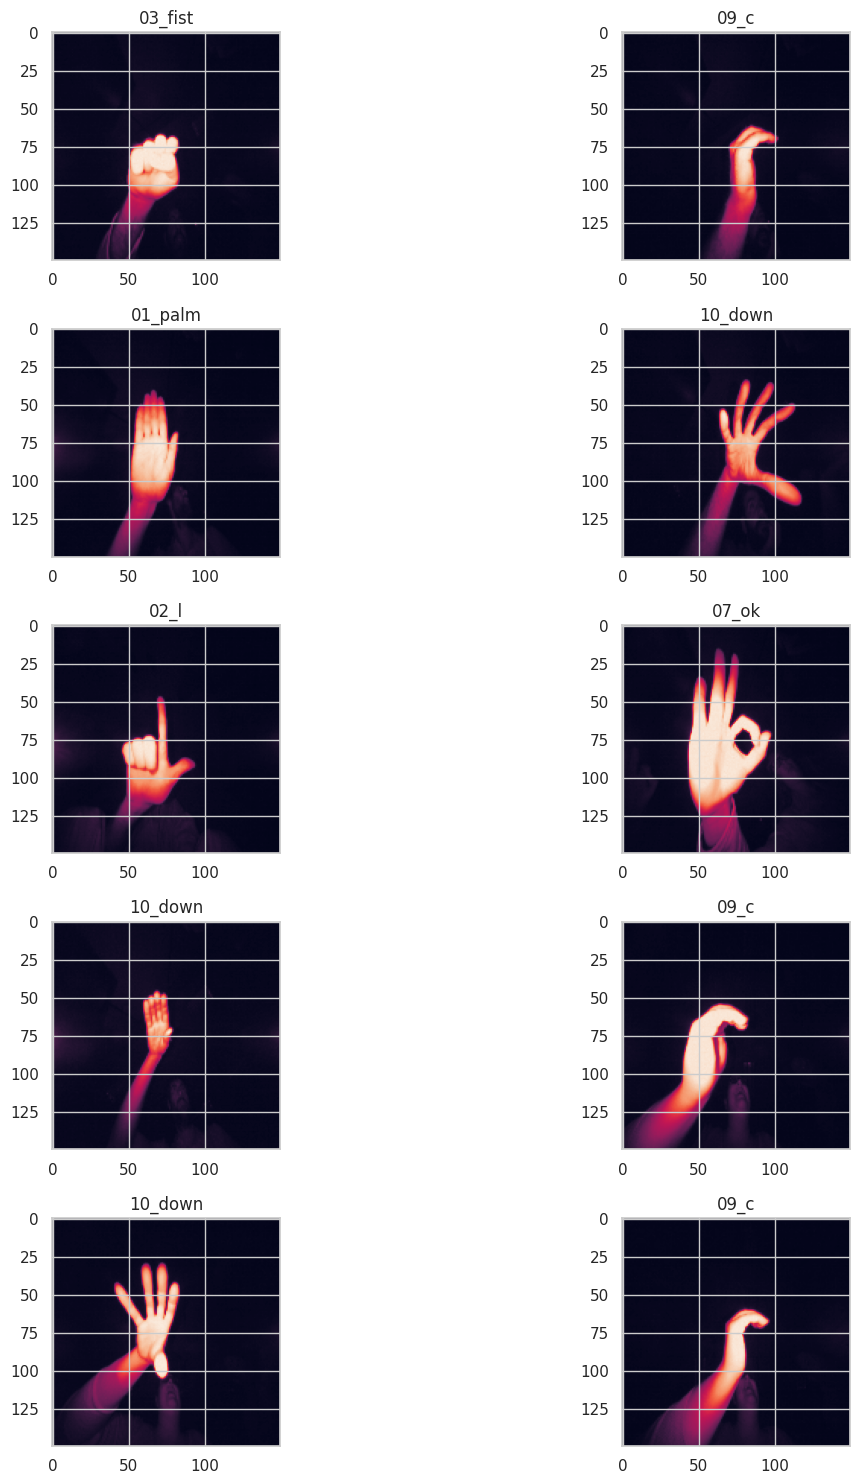

In [6]:

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])

plt.tight_layout()

In [7]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [22]:
x_data.shape

(20000, 150, 150, 1)

In [32]:
y_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### **Train-test Split**

In [8]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

### **Model Building**

In [9]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [10]:
batch_size=128
epochs=10

In [11]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [12]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

In [14]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8860
Epoch 1: val_loss improved from inf to 0.00786, saving model to ./base.model
118/118 [==============================] - 22s 123ms/step - loss: 0.3476 - accuracy: 0.8860 - val_loss: 0.0079 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 2/10
117/118 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9985
Epoch 2: val_loss improved from 0.00786 to 0.00450, saving model to ./base.model
118/118 [==============================] - 12s 103ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.0045 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 3/10
117/118 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9996
Epoch 3: val_loss improved from 0.00450 to 0.00043, saving model to ./base.model
118/118 [==============================] - 13s 107ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 4.3105e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
117/118 [========

### **Evaluation of Model**

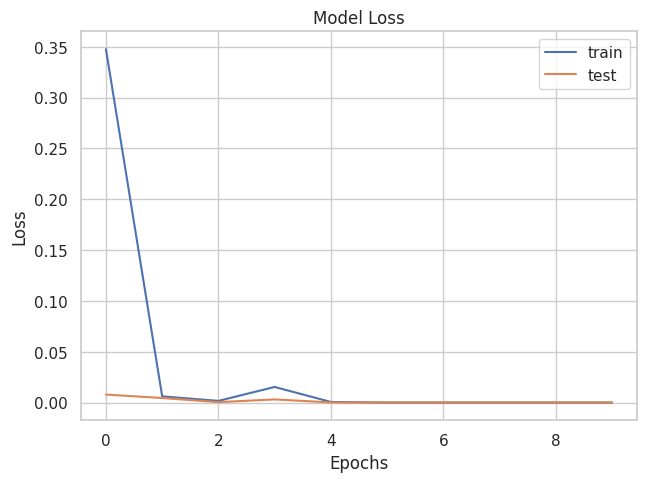

In [15]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

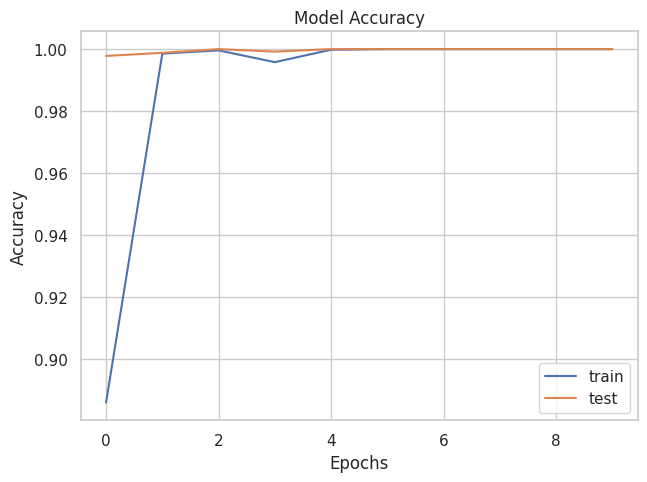

In [20]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### **Saving the Model**

Before saving the model we have to save the mapping in clean form

In [84]:
def clean_value(value):
    # Remove numbers and underscores, capitalize each word
    cleaned_value = ' '.join([word.capitalize() for word in value.split('_') if not word.isdigit()])
    return cleaned_value

mappping = {key: clean_value(value) for key, value in reverselookup.items()}
mappping


{0: 'Palm Moved',
 1: 'Fist',
 2: 'Index',
 3: 'Thumb',
 4: 'Fist Moved',
 5: 'C',
 6: 'L',
 7: 'Palm',
 8: 'Ok',
 9: 'Down'}

In [85]:
import json
model.save("hand-recognition.h5")
with open('class_mapping.json', 'w') as json_file:
    json.dump(mappping, json_file)

## **Using The Model For new Prediction**

In [1]:
import cv2
import numpy as np
from keras import models
import json

loaded_model = models.load_model("hand-recognition.h5",compile=False)
with open('class_mapping.json', 'r') as json_file:
    class_mapping = json.load(json_file)


IMG_SIZE=150
def prepare_image_for_prediction(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_array = np.array(img)

    # Reshape the image to (1, IMG_SIZE, IMG_SIZE, 1) as the model expects
    img_array = img_array.reshape((1, IMG_SIZE, IMG_SIZE, 1))

    # Normalize the pixel values
    img_array = img_array / 255.0

    return img_array


In [2]:
def get_prediction(img):
  # Prepare image for model prediction
  prepared_image = prepare_image_for_prediction(img)

  # getting prediction probabilities
  prediction = loaded_model.predict(prepared_image)

  # getting the index of highest probability
  key=str(np.argmax(prediction))

  # passing index to dict for class name
  class_name=class_mapping[key]
  return class_name


In [5]:
import gradio as gr

try:
    gr.Interface(fn=get_prediction,
                 title="Hand Gesture Recognition",
                 inputs=gr.Image(label='Input Image'),
                 outputs=gr.Label(label='Output Recognition'),
                 examples=['frame_00_01_0014.png','frame_00_10_0002.png','frame_00_02_0004.png','frame_00_04_0001.png','frame_00_05_0007.png','frame_00_08_0005.png'],    css="footer {visibility: hidden}"
                 ).launch()
except Exception as e:
    print(e.__class__)
    print(e.__cause__)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
